In [16]:
import scipy.io as sio
import os
import json

MPII_DATA_DIR = '/Users/zhumingyu/Desktop/2025SPRING/COMS6998/mpii_data'
MPII_OUT_DIR = '/Users/zhumingyu/Desktop/2025SPRING/COMS6998/mpii_data'

In [17]:
def save_joints():
    """
    Convert annotations mat file to json and save on disk.
    Only persons with annotations of all 16 joints will be written in the json.
    """
    joint_data_fn = os.path.join(MPII_OUT_DIR, 'data.json')
    mat = sio.loadmat(os.path.join(MPII_DATA_DIR, 'mpii_human_pose_v1_u12_1.mat'))

    fp = open(joint_data_fn, 'w')

    for i, (anno, train_flag) in enumerate(
        zip(mat['RELEASE']['annolist'][0, 0][0],
            mat['RELEASE']['img_train'][0, 0][0])):

        img_fn = anno['image']['name'][0, 0][0]
        train_flag = int(train_flag)

        if 'annopoints' in str(anno['annorect'].dtype):
            annopoints = anno['annorect']['annopoints'][0]
            head_x1s = anno['annorect']['x1'][0]
            head_y1s = anno['annorect']['y1'][0]
            head_x2s = anno['annorect']['x2'][0]
            head_y2s = anno['annorect']['y2'][0]
            for annopoint, head_x1, head_y1, head_x2, head_y2 in \
                    zip(annopoints, head_x1s, head_y1s, head_x2s, head_y2s):
                if len(annopoint) > 0:
                    head_rect = [float(head_x1[0, 0]),
                                 float(head_y1[0, 0]),
                                 float(head_x2[0, 0]),
                                 float(head_y2[0, 0])]

                    # joint coordinates
                    annopoint = annopoint['point'][0, 0]
                    j_id = [str(j_i[0, 0]) for j_i in annopoint['id'][0]]
                    x = [x[0, 0] for x in annopoint['x'][0]]
                    y = [y[0, 0] for y in annopoint['y'][0]]
                    joint_pos = {}
                    for _j_id, (_x, _y) in zip(j_id, zip(x, y)):
                        joint_pos[str(_j_id)] = [float(_x), float(_y)]
                    # joint_pos = fix_wrong_joints(joint_pos)

                    # visiblity list
                    if 'is_visible' in str(annopoint.dtype):
                        vis = [v[0] if v else [0]
                               for v in annopoint['is_visible'][0]]
                        vis = dict([(k, int(v[0])) if len(v) > 0 else v
                                    for k, v in zip(j_id, vis)])
                    else:
                        vis = None

                    if len(joint_pos) == 16:
                        data = {
                            'filename': img_fn,
                            'train': train_flag,
                            'head_rect': head_rect,
                            'is_visible': vis,
                            'joint_pos': joint_pos
                        }

                        print(json.dumps(data), file=fp)

In [18]:
save_joints()

/opt/anaconda3/envs/stock/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [19]:
with open(os.path.join(MPII_DATA_DIR, 'data.json'), 'r') as f:
    data = [json.loads(line) for line in f]
print(data[0])

{'filename': '015601864.jpg', 'train': 1, 'head_rect': [627.0, 100.0, 706.0, 198.0], 'is_visible': {'6': 0, '7': 1, '8': 0, '9': 0, '0': 1, '1': 1, '2': 1, '3': 0, '4': 1, '5': 1, '10': 1, '11': 1, '12': 1, '13': 1, '14': 1, '15': 1}, 'joint_pos': {'6': [610.0, 187.0], '7': [647.0, 176.0], '8': [637.0201, 189.8183], '9': [695.9799, 108.1817], '0': [620.0, 394.0], '1': [616.0, 269.0], '2': [573.0, 185.0], '3': [647.0, 188.0], '4': [661.0, 221.0], '5': [656.0, 231.0], '10': [606.0, 217.0], '11': [553.0, 161.0], '12': [601.0, 167.0], '13': [692.0, 185.0], '14': [693.0, 240.0], '15': [688.0, 313.0]}}


In [25]:
clean_list = []
for i in range(len(data)):
        clean_list.append(data[i]['filename'])
print(len(clean_list))
print(clean_list[0])

19919
015601864.jpg


In [21]:
import os

# Get all files in mpii folder
mpii_dir = 'mpii'
all_files = os.listdir(mpii_dir)
print(len(all_files))
orig_len = len(all_files)
counter = 0
# Delete files that are not in clean_list
for file in all_files:
    if file not in clean_list:
        file_path = os.path.join(mpii_dir, file)
        os.remove(file_path)
        counter = counter + 1

assert (counter + len(os.listdir(mpii_dir))==orig_len)

24984


In [22]:
all_files = os.listdir('mpii')
print(len(all_files))

12055


In [23]:
print(len(clean_list))

19919


In [26]:
import os
import random
import shutil

# Set the seed for reproducibility
random.seed(42)

# Source folder containing images
src_folder = 'mpii'

# Destination folders
dst_root = 'mpii_split'
train_folder = os.path.join(dst_root, 'train')
val_folder = os.path.join(dst_root, 'val')
test_folder = os.path.join(dst_root, 'test')

# Create destination folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get all image files from the source folder
images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(images)

# Compute split sizes
total = len(images)
train_end = int(total * 0.7)
val_end = train_end + int(total * 0.15)

# Split the images
train_images = images[:train_end]
val_images = images[train_end:val_end]
test_images = images[val_end:]

# Helper to copy images
def copy_images(image_list, dest_folder):
    for img in image_list:
        shutil.copy2(os.path.join(src_folder, img), os.path.join(dest_folder, img))

# Copy the images
copy_images(train_images, train_folder)
copy_images(val_images, val_folder)
copy_images(test_images, test_folder)

print(f"Total images: {total}")
print(f"Train: {len(train_images)} | Val: {len(val_images)} | Test: {len(test_images)}")


Total images: 12055
Train: 8438 | Val: 1808 | Test: 1809


In [30]:
name_mapping = {

 0: "r ankle",
 1: "r knee",
 2: "r hip",
 3: "l hip",
 4: "l knee",
 5: "l ankle",
 6: "pelvis",
 7: "thorax",
 8: "upper neck",
 9: "head top",
10: "r wrist",
11: "r elbow",
12: "r shoulder",
13: "l shoulder",
14: "l elbow",
15: "l wrist"
}

In [33]:
first_data_point = data[0]
first_data_point_joint_pos = first_data_point['joint_pos']
first_data_point_filename = first_data_point['filename']

In [37]:
first_data_point_joint_pos

{'6': [610.0, 187.0],
 '7': [647.0, 176.0],
 '8': [637.0201, 189.8183],
 '9': [695.9799, 108.1817],
 '0': [620.0, 394.0],
 '1': [616.0, 269.0],
 '2': [573.0, 185.0],
 '3': [647.0, 188.0],
 '4': [661.0, 221.0],
 '5': [656.0, 231.0],
 '10': [606.0, 217.0],
 '11': [553.0, 161.0],
 '12': [601.0, 167.0],
 '13': [692.0, 185.0],
 '14': [693.0, 240.0],
 '15': [688.0, 313.0]}

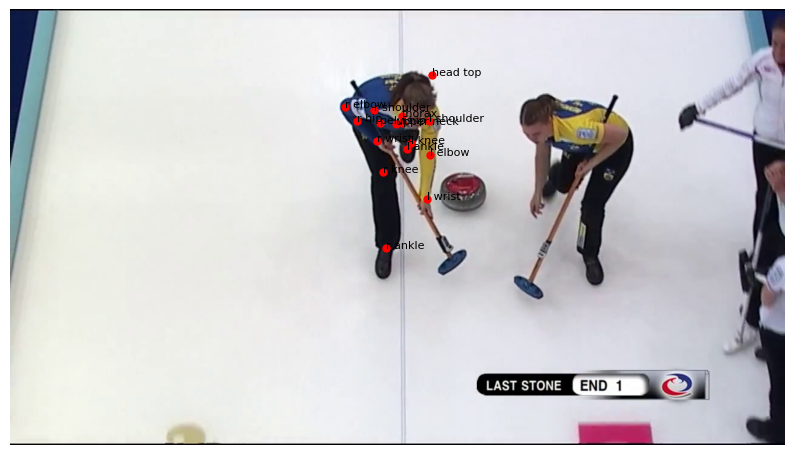

In [38]:
import cv2
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread(os.path.join(os.path.join(MPII_DATA_DIR, 'mpii'), first_data_point_filename))
# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

# Plot keypoints
for key in first_data_point_joint_pos.keys():
    x, y = first_data_point_joint_pos[key]
    ax.plot(x, y, 'o', color='red', markersize=5)
    joint_name = name_mapping[int(key)]
    ax.text(x, y, joint_name, fontsize=8)

plt.axis('off')
plt.show()
